# Chapter 1 — Audio Fundamentals: Hands-On with Vietnamese Speech

This notebook accompanies **Chapter 01** of the VieNeu-TTS deep learning guide.  
We will go from a raw Vietnamese WAV file all the way to MFCCs, building every representation by hand so you can see exactly what each step does.

**Prerequisites**: Python 3.9+, librosa, numpy, matplotlib, soundfile

**What we cover**:
1. Load a Vietnamese audio sample
2. Visualize the waveform (time domain)
3. Compute and visualize the STFT
4. Build the Mel spectrogram
5. Extract MFCCs + delta features
6. Demonstrate Nyquist aliasing
7. Explore the time-frequency resolution trade-off

In [1]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [2]:
# Install dependencies if needed
# Uncomment the line below if running in a fresh environment
# !pip install librosa numpy matplotlib soundfile ipython

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display

# Set matplotlib style for clear plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print(f"librosa version: {librosa.__version__}")
print(f"numpy version:   {np.__version__}")
print("All imports successful.")

# ── Path resolver (works regardless of Jupyter CWD) ──────────────
from pathlib import Path
import os as _os

def _find_examples_dir():
    # Walk up from CWD (works locally when kernel starts in chapters/)
    for _p in [Path(_os.getcwd())] + list(Path(_os.getcwd()).parents):
        _d = _p / "examples" / "audio_ref"
        if _d.is_dir():
            return _d
    # Colab fallback paths
    for _candidate in [
        Path("/content/vietnamese-tts-course/examples/audio_ref"),
        Path("/content/VieNeu-TTS/examples/audio_ref"),
    ]:
        if _candidate.is_dir():
            return _candidate
    raise FileNotFoundError(
        "examples/audio_ref/ not found. "
        "Clone the repo: git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git"
    )

EXAMPLES_DIR = _find_examples_dir()
print(f"Examples dir: {EXAMPLES_DIR}")

librosa version: 0.11.0
numpy version:   2.0.2
All imports successful.
Examples dir: /content/VieNeu-TTS/examples/audio_ref


## 1. Load a Vietnamese Audio Sample

We load the VieNeu-TTS reference audio sample — a short Vietnamese sentence spoken by a native speaker.  
The key parameters we need to know:
- **Sample rate** `sr`: How many samples per second (should be 24,000 Hz for VieNeu-TTS)
- **Duration**: Length of the audio in seconds
- **Samples**: Total number of discrete amplitude values in the array

> **Mathematical reminder**: The digital audio array `y` satisfies `y[n] = x(n / sr)` where `x(t)` is the original analog pressure wave.

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

# Load example audio (VieNeu-TTS reference sample)
# sr=None preserves the original sample rate instead of resampling to 22050 Hz
audio_path = str(EXAMPLES_DIR / "example.wav")
y, sr = librosa.load(audio_path, sr=None)

print(f"Sample rate:      {sr} Hz")
print(f"Duration:         {len(y)/sr:.3f} s")
print(f"Total samples:    {len(y):,}")
print(f"Data type:        {y.dtype}")
print(f"Amplitude range:  [{y.min():.4f}, {y.max():.4f}]")
print(f"Nyquist limit:    {sr//2:,} Hz  (max representable frequency)")
print()
print(f"This audio covers frequencies up to {sr//2} Hz.")
print(f"Vietnamese speech critical range: 80 Hz (F0) to ~12000 Hz (fricatives).")
print(f"Both are well within the {sr//2} Hz Nyquist limit.")

# Play audio in notebook
Audio(y, rate=sr)

Sample rate:      24000 Hz
Duration:         2.475 s
Total samples:    59,392
Data type:        float32
Amplitude range:  [-0.5554, 0.4543]
Nyquist limit:    12,000 Hz  (max representable frequency)

This audio covers frequencies up to 12000 Hz.
Vietnamese speech critical range: 80 Hz (F0) to ~12000 Hz (fricatives).
Both are well within the 12000 Hz Nyquist limit.


## 2. Waveform — Time Domain

The **waveform** is the most basic representation: a 1D array of amplitude values over time.  
Each sample `y[n]` is the air pressure displacement at time `t = n / sr` seconds.

For Vietnamese speech, different tones have visually distinct waveform shapes:
- **Ngang** (flat tone): Regular, uniform cycles with stable amplitude
- **Huyền** (falling tone): Cycles gradually lengthen (period increases = pitch falls); slightly irregular amplitude (breathiness)
- **Sắc** (rising tone): Cycles get shorter (period decreases = pitch rises); amplitude increases
- **Nặng** (low falling): Short duration, abrupt termination

$$x(t) = A\cos(2\pi f_0(t) \cdot t + \phi)$$

where $f_0(t)$ varies over time according to the tone contour.

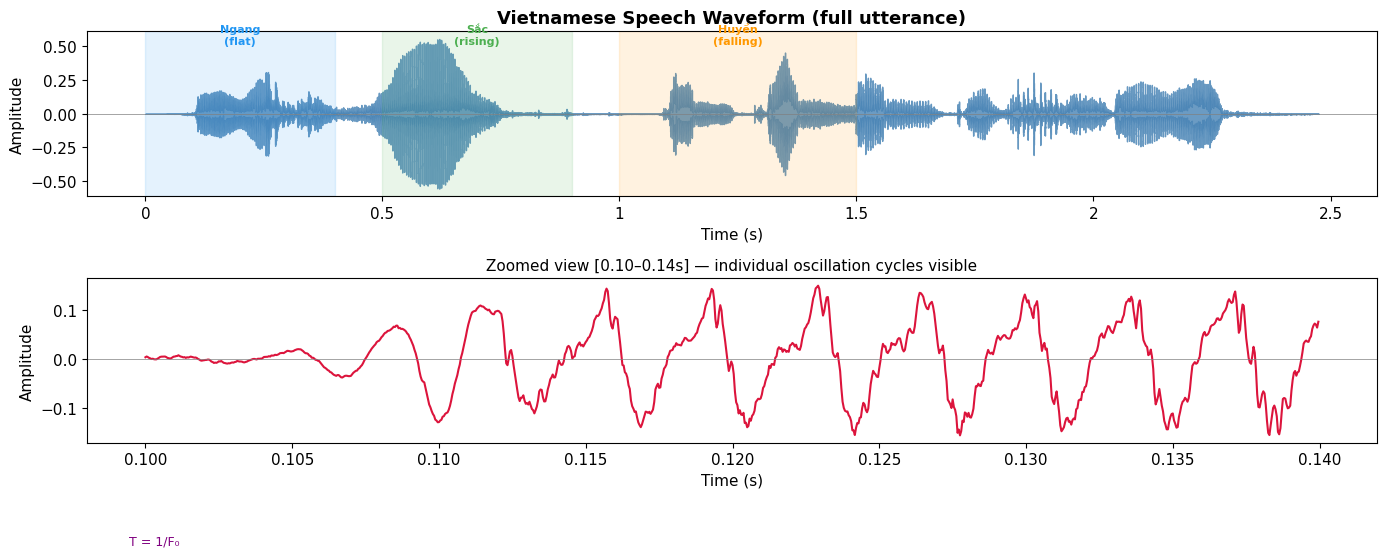


If F0 ≈ 150 Hz (typical Vietnamese male), one period T = 6.67 ms
At sr=24000 Hz, one period = 160 samples


In [4]:
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# --- Full waveform ---
ax = axes[0]
librosa.display.waveshow(y, sr=sr, ax=ax, color='steelblue', alpha=0.8)
ax.set_title("Vietnamese Speech Waveform (full utterance)", fontsize=13, fontweight='bold')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.axhline(0, color='gray', linewidth=0.5)

# Annotate approximate tone regions (adjust times based on your audio)
tone_annotations = [
    (0.0, 0.4, 'Ngang\n(flat)'),
    (0.5, 0.9, 'Sắc\n(rising)'),
    (1.0, 1.5, 'Huyền\n(falling)'),
]
colors_tone = ['#2196F3', '#4CAF50', '#FF9800']
for (t_start, t_end, label), color in zip(tone_annotations, colors_tone):
    ax.axvspan(t_start, t_end, alpha=0.12, color=color)
    ax.text((t_start + t_end)/2, ax.get_ylim()[1]*0.85, label,
            ha='center', fontsize=8, color=color, fontweight='bold')

# --- Zoomed waveform to see individual cycles ---
ax2 = axes[1]
zoom_start_s = 0.1
zoom_dur_s   = 0.04  # 40 ms — shows ~4–6 cycles at 150 Hz F0
zoom_start = int(zoom_start_s * sr)
zoom_end   = int((zoom_start_s + zoom_dur_s) * sr)
t_zoom = np.arange(zoom_start, zoom_end) / sr
ax2.plot(t_zoom, y[zoom_start:zoom_end], color='crimson', linewidth=1.5)
ax2.set_title(f"Zoomed view [{zoom_start_s:.2f}–{zoom_start_s+zoom_dur_s:.2f}s] — individual oscillation cycles visible",
              fontsize=11)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude")
ax2.axhline(0, color='gray', linewidth=0.5)

# Annotate one period
ax2.annotate('', xy=(t_zoom[15], -0.3), xytext=(t_zoom[0], -0.3),
             arrowprops=dict(arrowstyle='<->', color='purple', lw=1.5))
ax2.text((t_zoom[0]+t_zoom[15])/2, -0.38, 'T = 1/F₀', ha='center', fontsize=9, color='purple')

plt.tight_layout()
plt.savefig('ch01_waveform.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nIf F0 ≈ 150 Hz (typical Vietnamese male), one period T = {1/150*1000:.2f} ms")
print(f"At sr={sr} Hz, one period = {sr/150:.0f} samples")

## 3. Short-Time Fourier Transform (STFT)

The **STFT** gives us a 2D time-frequency representation by computing the DFT on short overlapping windows:

$$X[m, k] = \sum_{n} x[n] \, w[n - mH] \, e^{-j2\pi kn/N}$$

where $m$ = frame index, $k$ = frequency bin, $H$ = hop length, $N$ = FFT size.

**Key parameters and their effect**:
- `n_fft` ($N$): FFT size → frequency resolution $\Delta f = f_s / N$ Hz per bin
- `hop_length` ($H$): Step between frames → time resolution $\Delta t = H / f_s$ seconds
- `win_length`: Window size (default = n_fft)

The output `D` is a complex matrix with shape `(1 + n_fft//2, n_frames)`.  
The **magnitude** `|D|` tells us how much of each frequency is present; the **phase** `angle(D)` tells us the phase offset.

=== STFT Properties ===
n_fft:               1024 samples
hop_length:          256 samples
STFT shape:          (513, 233)  (freq_bins × time_frames)
Freq bins:           513  (0 to 12000 Hz)
Time frames:         233

Frequency resolution: Δf = 24000/1024 = 23.44 Hz per bin
Time resolution:      Δt = 256/24000 = 10.67 ms per frame
Window duration:      1024/24000*1000 = 42.67 ms

For Vietnamese F0 = 150 Hz:
  F0 falls in bin #6 (at 150 Hz)
  2nd harmonic in bin #12 (at 300 Hz)


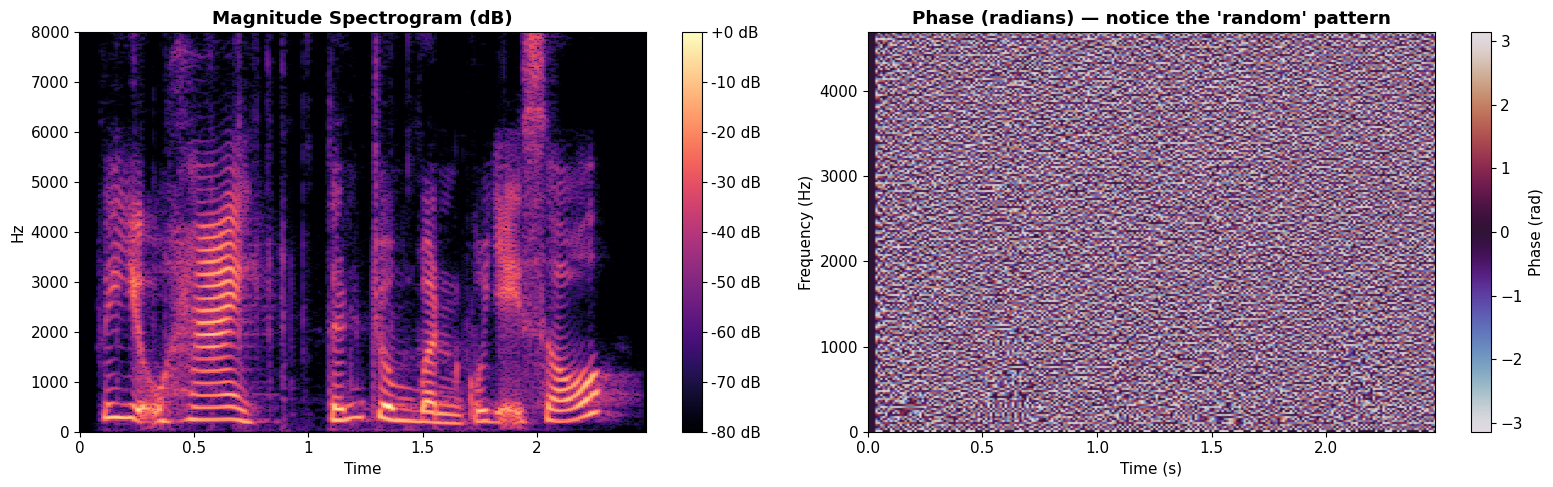


Note: Phase looks 'random' but is necessary for waveform reconstruction.
VieNeu-TTS NeuCodec uses learned phase estimation — it does NOT discard phase.


In [5]:
# Compute STFT with VieNeu-TTS default parameters
n_fft      = 1024
hop_length = 256
win_length = 1024

D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
                 window='hann', center=True)

magnitude = np.abs(D)       # |X[m,k]|  — always non-negative
phase     = np.angle(D)     # angle(X[m,k]) — in [-pi, pi]
power     = magnitude ** 2  # |X[m,k]|^2

print("=== STFT Properties ===")
print(f"n_fft:               {n_fft} samples")
print(f"hop_length:          {hop_length} samples")
print(f"STFT shape:          {D.shape}  (freq_bins × time_frames)")
print(f"Freq bins:           {D.shape[0]}  (0 to {sr//2} Hz)")
print(f"Time frames:         {D.shape[1]}")
print()
print(f"Frequency resolution: Δf = {sr}/{n_fft} = {sr/n_fft:.2f} Hz per bin")
print(f"Time resolution:      Δt = {hop_length}/{sr} = {hop_length/sr*1000:.2f} ms per frame")
print(f"Window duration:      {win_length}/{sr}*1000 = {win_length/sr*1000:.2f} ms")
print()
print(f"For Vietnamese F0 = 150 Hz:")
print(f"  F0 falls in bin #{150 // (sr/n_fft):.0f} (at {150:.0f} Hz)")
print(f"  2nd harmonic in bin #{300 // (sr/n_fft):.0f} (at 300 Hz)")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Magnitude spectrogram (dB scale)
img1 = librosa.display.specshow(
    librosa.amplitude_to_db(magnitude, ref=np.max),
    sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz',
    ax=axes[0], cmap='magma'
)
axes[0].set_title("Magnitude Spectrogram (dB)", fontweight='bold')
axes[0].set_ylim(0, 8000)  # Focus on speech range
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

# Phase spectrogram
img2 = axes[1].imshow(
    phase[:200, :],  # Show only first 200 freq bins for clarity
    aspect='auto', origin='lower', cmap='twilight',
    extent=[0, len(y)/sr, 0, 200 * sr/n_fft]
)
axes[1].set_title("Phase (radians) — notice the 'random' pattern", fontweight='bold')
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (Hz)")
fig.colorbar(img2, ax=axes[1], label='Phase (rad)')

plt.tight_layout()
plt.savefig('ch01_stft.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNote: Phase looks 'random' but is necessary for waveform reconstruction.")
print("VieNeu-TTS NeuCodec uses learned phase estimation — it does NOT discard phase.")

## 4. Mel Spectrogram

The **mel spectrogram** applies a triangular mel filterbank to the power spectrogram, compressing the frequency axis from linear Hz to the perceptual mel scale:

$$m = 2595 \times \log_{10}\!\left(1 + \frac{f}{700}\right)$$

With 80 mel bins, the spectrogram focuses most resolution on the perceptually important 0–4 kHz range (where vowel formants and tone F0 live), and fewer bins on the 4–12 kHz range.

**VieNeu-TTS uses the mel spectrogram for:**
- Training loss computation (predicted mel vs target mel)
- Visualization and debugging
- The mel filterbank matrix is a fixed, non-learned transformation

Mel spectrogram shape: (80, 233)  (80 mel bins × 233 time frames)
Value range (dB):      [-80.0, 0.0] dB

Mel filterbank matrix shape: (80, 513)  (80 filters × 513 FFT bins)


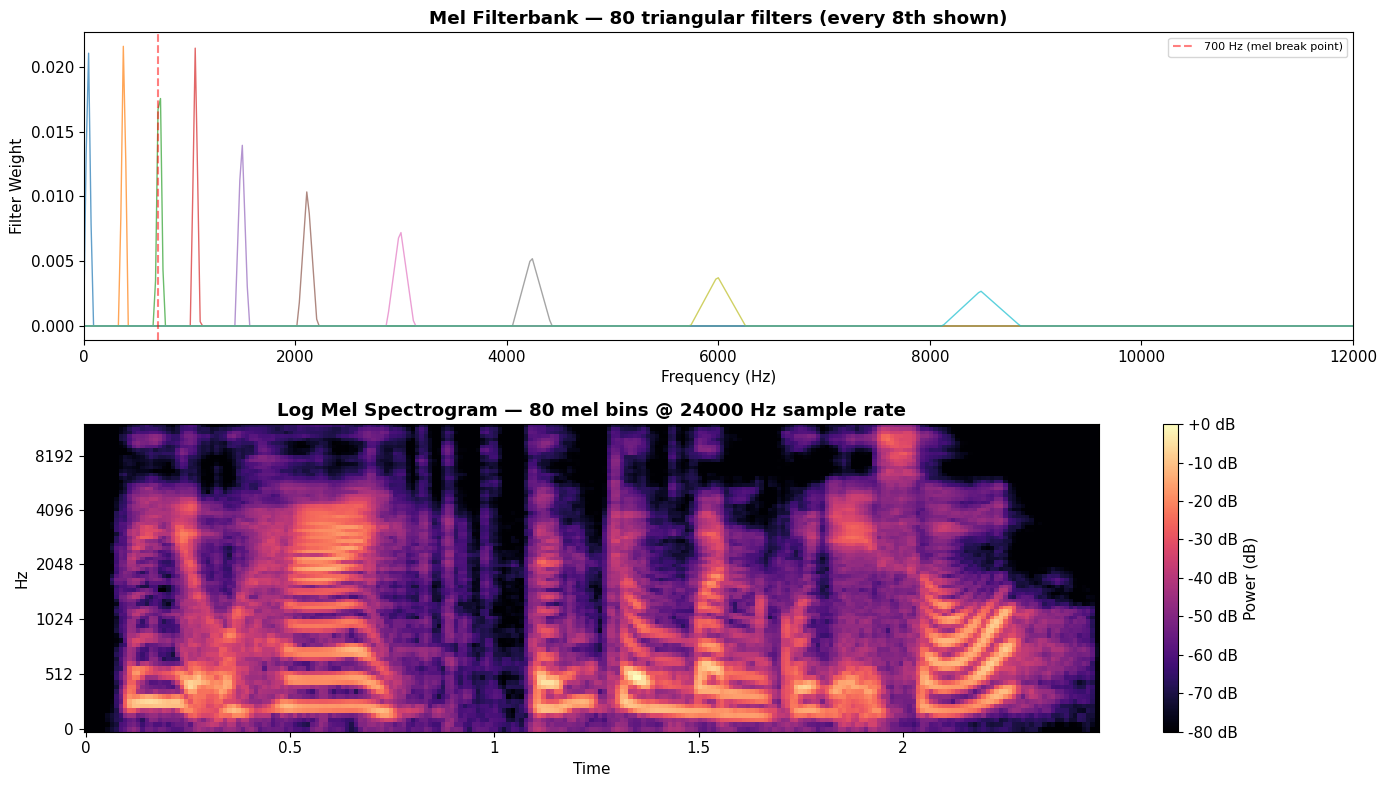


Observation: Most energy is concentrated in the 0-4 kHz band (vowels, F0, formants).
The mel scale uses more bins here and fewer bins at 4-12 kHz — matching human perception.


In [6]:
n_mels = 80  # VieNeu-TTS default: 80 mel bins
fmin   = 0   # Minimum frequency (Hz)
fmax   = None  # Maximum frequency (None = sr/2 = Nyquist)

# Compute mel spectrogram
mel_spec = librosa.feature.melspectrogram(
    y=y, sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax
)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

print(f"Mel spectrogram shape: {mel_spec.shape}  ({n_mels} mel bins × {mel_spec.shape[1]} time frames)")
print(f"Value range (dB):      [{mel_db.min():.1f}, {mel_db.max():.1f}] dB")
print()

# Show the mel filterbank itself
mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
print(f"Mel filterbank matrix shape: {mel_filter.shape}  ({n_mels} filters × {n_fft//2+1} FFT bins)")

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# --- Plot mel filterbank ---
ax0 = axes[0]
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
for i in range(0, n_mels, 8):  # Show every 8th filter to avoid clutter
    ax0.plot(freqs, mel_filter[i], alpha=0.7, linewidth=1)
ax0.set_title(f"Mel Filterbank — {n_mels} triangular filters (every 8th shown)", fontweight='bold')
ax0.set_xlabel("Frequency (Hz)")
ax0.set_ylabel("Filter Weight")
ax0.set_xlim(0, sr//2)
ax0.axvline(700, color='red', linestyle='--', alpha=0.5, label='700 Hz (mel break point)')
ax0.legend(fontsize=8)

# --- Mel Spectrogram ---
ax1 = axes[1]
img = librosa.display.specshow(
    mel_db, sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='mel',
    ax=ax1, cmap='magma'
)
ax1.set_title(f"Log Mel Spectrogram — {n_mels} mel bins @ {sr} Hz sample rate", fontweight='bold')
fig.colorbar(img, ax=ax1, format='%+2.0f dB', label='Power (dB)')

plt.tight_layout()
plt.savefig('ch01_mel.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nObservation: Most energy is concentrated in the 0-4 kHz band (vowels, F0, formants).")
print("The mel scale uses more bins here and fewer bins at 4-12 kHz — matching human perception.")

## 5. MFCCs — Mel-Frequency Cepstral Coefficients

MFCCs apply a **DCT** to the log mel spectrogram to decorrelate the filterbank outputs:

$$c[n] = \sum_{k=0}^{K-1} \log(S[k]) \cos\!\left(\frac{\pi n(k+0.5)}{K}\right)$$

The first 13 coefficients capture the **spectral envelope**. Delta and delta-delta MFCCs capture **temporal dynamics** — critically important for Vietnamese tone analysis:

| Feature | What it captures | Vietnamese relevance |
|---------|-----------------|---------------------|
| MFCC (static) | Vowel quality, timbre | Same for all tones on same vowel |
| Delta MFCC | Rate of spectral change | Encodes tone contour direction |
| Delta-delta MFCC | Acceleration of change | Encodes contour shape (dip, break) |

MFCC shape:        (13, 233)    (13 coefficients × 233 frames)
Delta MFCC shape:  (13, 233)
Delta² MFCC shape: (13, 233)
Full feature (stacked): (39, 233)  (39 dims × 233 frames)


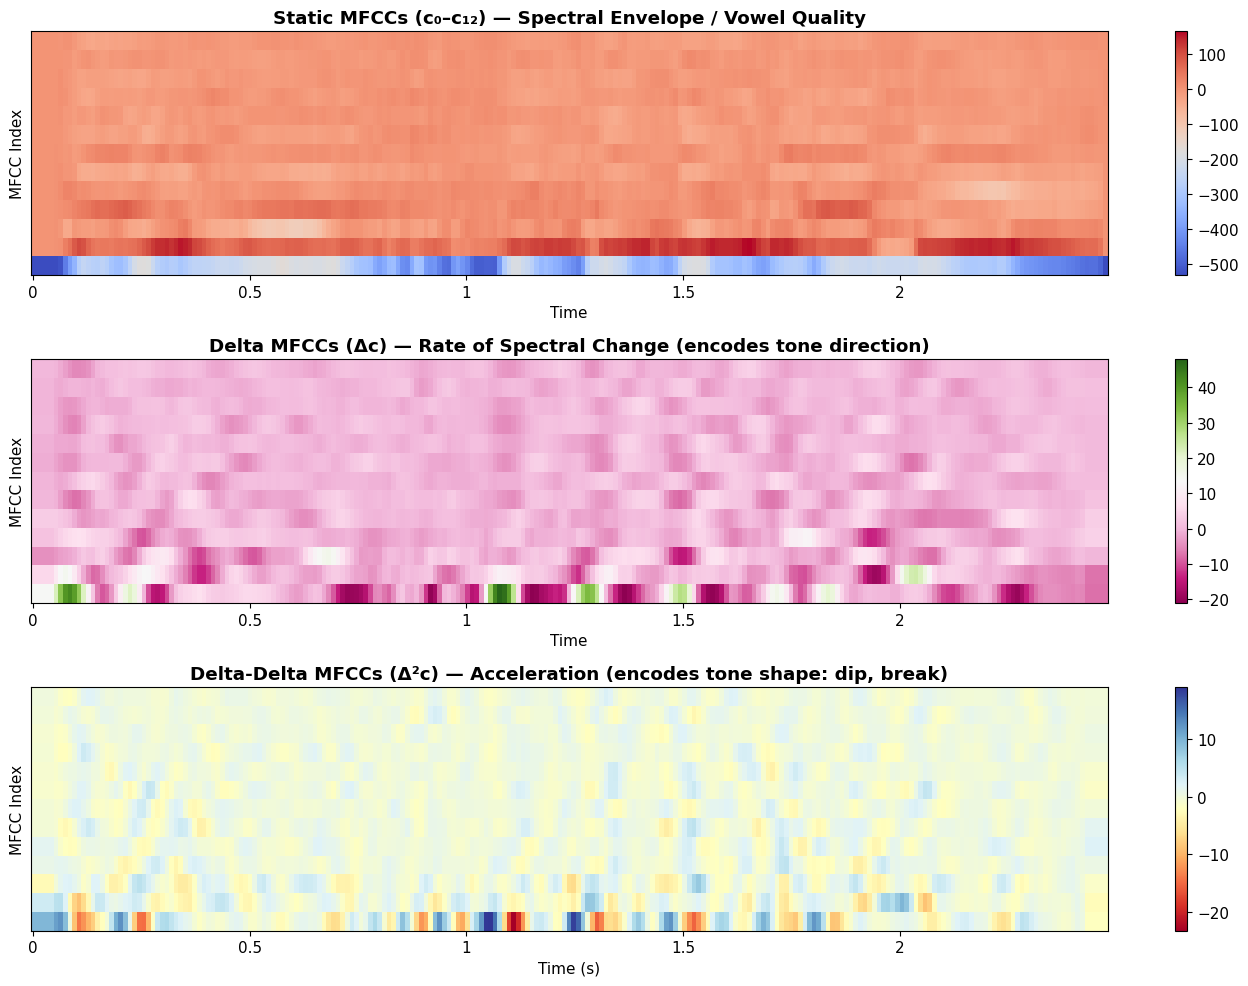


Vietnamese tone fingerprints in MFCC features:
  Ngang  (flat):    Δc[1] ≈ 0   (no change in spectral tilt)
  Huyền  (falling): Δc[1] < 0   (spectrum tilts toward lower freqs as pitch falls)
  Sắc    (rising):  Δc[1] > 0   (spectrum brightens as pitch rises)
  Hỏi   (dipping): Δ²c[1] sign changes  (first falls then rises = inflection)
  Nặng  (abrupt):  Large Δ²c negative spike at endpoint (fast deceleration)


In [7]:
n_mfcc = 13  # Standard: keep first 13 coefficients

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc,
                               n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# Compute delta and delta-delta
mfcc_delta  = librosa.feature.delta(mfccs, order=1)  # Velocity
mfcc_delta2 = librosa.feature.delta(mfccs, order=2)  # Acceleration

# Stack into full 39-dim feature vector
mfcc_full = np.vstack([mfccs, mfcc_delta, mfcc_delta2])

print(f"MFCC shape:        {mfccs.shape}    ({n_mfcc} coefficients × {mfccs.shape[1]} frames)")
print(f"Delta MFCC shape:  {mfcc_delta.shape}")
print(f"Delta² MFCC shape: {mfcc_delta2.shape}")
print(f"Full feature (stacked): {mfcc_full.shape}  ({3*n_mfcc} dims × {mfccs.shape[1]} frames)")

# Visualize all three layers
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

titles = [
    f"Static MFCCs (c₀–c₁₂) — Spectral Envelope / Vowel Quality",
    f"Delta MFCCs (Δc) — Rate of Spectral Change (encodes tone direction)",
    f"Delta-Delta MFCCs (Δ²c) — Acceleration (encodes tone shape: dip, break)",
]
features = [mfccs, mfcc_delta, mfcc_delta2]
cmaps    = ['coolwarm', 'PiYG', 'RdYlBu']

for ax, feat, title, cmap in zip(axes, features, titles, cmaps):
    img = librosa.display.specshow(feat, sr=sr, hop_length=hop_length,
                                    x_axis='time', ax=ax, cmap=cmap)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel("MFCC Index")
    fig.colorbar(img, ax=ax)

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig('ch01_mfcc.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVietnamese tone fingerprints in MFCC features:")
print("  Ngang  (flat):    Δc[1] ≈ 0   (no change in spectral tilt)")
print("  Huyền  (falling): Δc[1] < 0   (spectrum tilts toward lower freqs as pitch falls)")
print("  Sắc    (rising):  Δc[1] > 0   (spectrum brightens as pitch rises)")
print("  Hỏi   (dipping): Δ²c[1] sign changes  (first falls then rises = inflection)")
print("  Nặng  (abrupt):  Large Δ²c negative spike at endpoint (fast deceleration)")

## 6. Nyquist Demo — Aliasing

The **Nyquist-Shannon theorem** states that to faithfully represent a signal with bandwidth $B$ Hz,  
you must sample at $f_s \geq 2B$ Hz.

If $f_s < 2B$, high-frequency components **alias** — they appear as spurious lower-frequency components:

$$f_{\text{alias}} = |f - k f_s|, \quad \text{for integer } k \text{ s.t. } f_{\text{alias}} \in [0, f_s/2]$$

Here we demonstrate aliasing by generating a 440 Hz tone (the musical note A4, used as a reference pitch in Vietnamese music), then undersampling it to cause aliasing.

Original frequency:   440.0 Hz
Undersample rate:     800 Hz
Nyquist limit:        400 Hz
Alias frequency:      |440 - 800| = 360 Hz
→ 440 Hz appears as 360 Hz after undersampling!


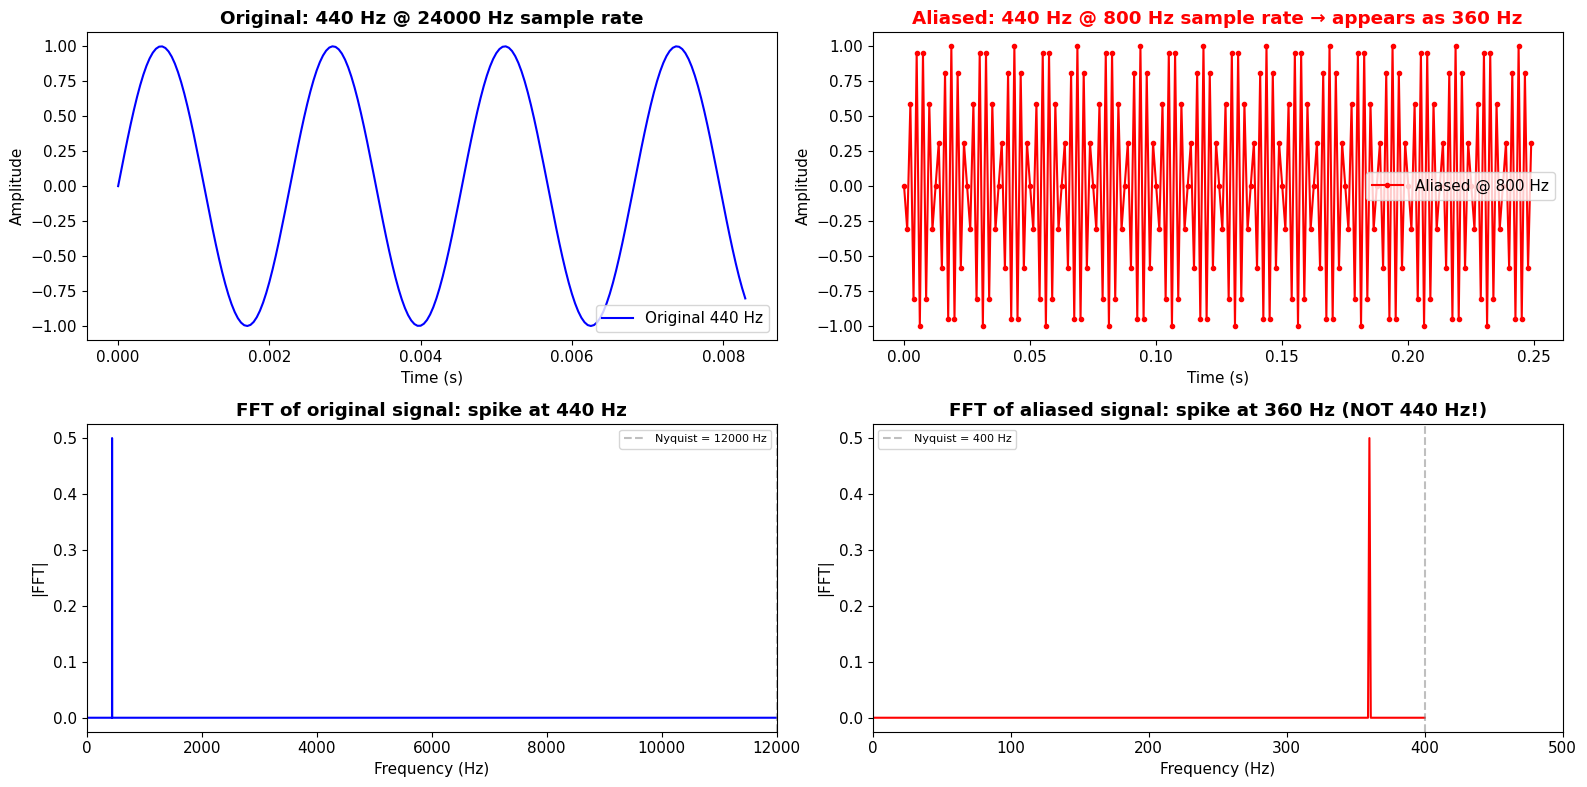


Conclusion: Sampling below Nyquist rate creates phantom frequencies.
VieNeu-TTS uses 24 kHz to prevent aliasing for Vietnamese speech up to 12 kHz.

Listen to both:


In [8]:
# Generate reference tone: 440 Hz (A4 = concert pitch, used in Vietnamese traditional music)
sr_high = 24000   # High quality sample rate (VieNeu-TTS standard)
sr_low  = 800     # Intentionally low — Nyquist = 400 Hz < 440 Hz → aliasing!
duration = 1.0    # 1 second

t_high = np.linspace(0, duration, int(sr_high * duration), endpoint=False)
t_low  = np.linspace(0, duration, int(sr_low  * duration), endpoint=False)

freq_original = 440.0  # Hz — A4

# Original high-quality signal
signal_high = np.sin(2 * np.pi * freq_original * t_high)

# Undersampled signal (sampled at sr_low=800 Hz with Nyquist=400 Hz)
signal_low = np.sin(2 * np.pi * freq_original * t_low)

# Calculate alias frequency
# 440 Hz sampled at 800 Hz:
# 440 mod 800 = 440; but 440 > 400 (Nyquist), so alias = |440 - 800| = 360 Hz
f_alias = abs(freq_original - sr_low)
print(f"Original frequency:   {freq_original} Hz")
print(f"Undersample rate:     {sr_low} Hz")
print(f"Nyquist limit:        {sr_low//2} Hz")
print(f"Alias frequency:      |{freq_original:.0f} - {sr_low}| = {f_alias:.0f} Hz")
print(f"→ 440 Hz appears as {f_alias:.0f} Hz after undersampling!")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
zoom_samples = 200  # Show first 200 samples

# Time domain comparison
axes[0,0].plot(t_high[:zoom_samples], signal_high[:zoom_samples], 'b-', linewidth=1.5, label=f'Original {freq_original:.0f} Hz')
axes[0,0].set_title(f"Original: {freq_original:.0f} Hz @ {sr_high} Hz sample rate", fontweight='bold')
axes[0,0].set_xlabel("Time (s)")
axes[0,0].set_ylabel("Amplitude")
axes[0,0].legend()

axes[0,1].plot(t_low[:min(zoom_samples, len(t_low))],
               signal_low[:min(zoom_samples, len(t_low))],
               'r-o', linewidth=1.5, markersize=3, label=f'Aliased @ {sr_low} Hz')
axes[0,1].set_title(f"Aliased: {freq_original:.0f} Hz @ {sr_low} Hz sample rate → appears as {f_alias:.0f} Hz",
                    fontweight='bold', color='red')
axes[0,1].set_xlabel("Time (s)")
axes[0,1].set_ylabel("Amplitude")
axes[0,1].legend()

# Frequency domain comparison
def plot_fft(ax, signal, sr, title, color):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, 1/sr)
    fft_mag = np.abs(np.fft.rfft(signal)) / N
    ax.plot(freqs, fft_mag, color=color, linewidth=1.5)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("|FFT|")
    ax.set_xlim(0, max(sr//2, 500))
    ax.axvline(sr//2, color='gray', linestyle='--', alpha=0.5, label=f'Nyquist = {sr//2} Hz')
    ax.legend(fontsize=8)

plot_fft(axes[1,0], signal_high, sr_high,
         f"FFT of original signal: spike at {freq_original:.0f} Hz", 'blue')

plot_fft(axes[1,1], signal_low, sr_low,
         f"FFT of aliased signal: spike at {f_alias:.0f} Hz (NOT {freq_original:.0f} Hz!)", 'red')

plt.tight_layout()
plt.savefig('ch01_aliasing.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConclusion: Sampling below Nyquist rate creates phantom frequencies.")
print("VieNeu-TTS uses 24 kHz to prevent aliasing for Vietnamese speech up to 12 kHz.")
print()
print("Listen to both:")
display(Audio(signal_high, rate=sr_high))
display(Audio(signal_low,  rate=sr_low))

## 7. Effect of Hop Length & Window Size (Time-Frequency Trade-off)

The **Heisenberg-Gabor uncertainty principle** for signals states:

$$\Delta t \cdot \Delta f \geq \frac{1}{4\pi}$$

You cannot simultaneously have:
- **High time resolution** (fine temporal detail) — requires *small* window
- **High frequency resolution** (fine spectral detail) — requires *large* window

This grid shows 4 parameter combinations. Look at how the F0 harmonics and temporal boundaries change.

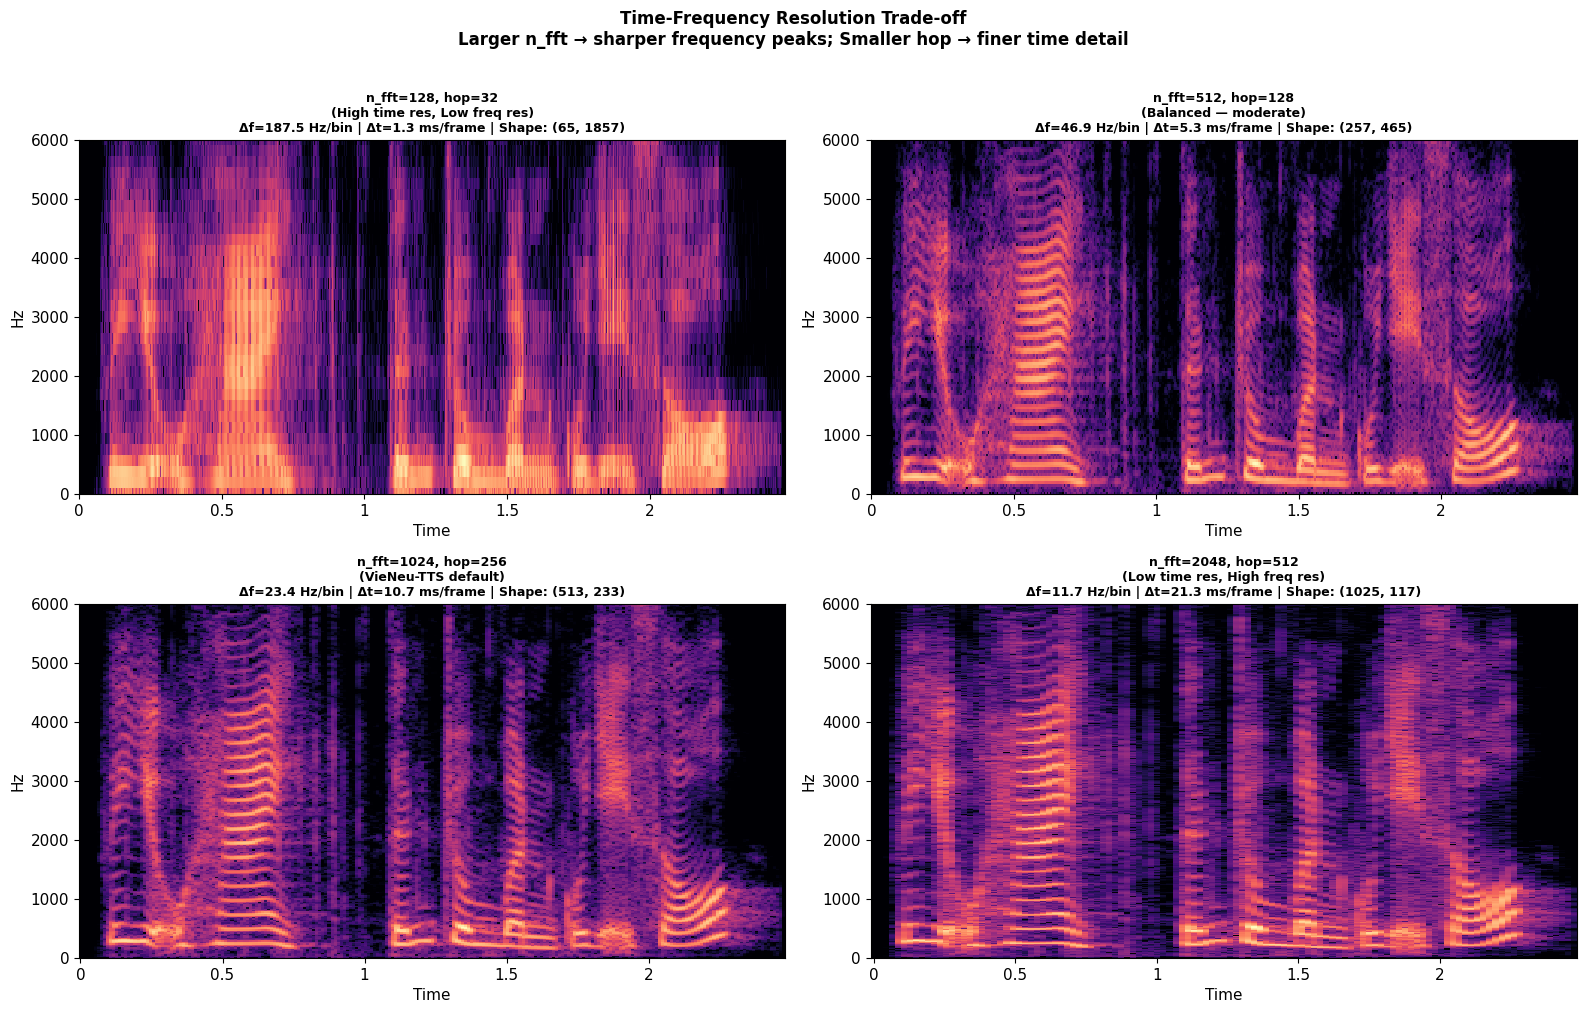


Analysis:
  n_fft=128:  You can see individual 'puffs' of consonants but F0 harmonics are blurred
  n_fft=2048: F0 harmonics are razor-sharp but consonant transitions smear across 85ms
  n_fft=1024: VieNeu-TTS choice — both F0 harmonics AND consonant boundaries are visible

For Vietnamese:
  - F0 resolution needed: < 10 Hz (distinguish 150 Hz from 160 Hz = semitone apart)
    n_fft=1024 gives 23.4 Hz/bin ✓
  - Temporal resolution needed: < 20 ms (resolve consonant closures, tone onsets)
    hop=256 gives 10.7 ms/frame ✓


In [9]:
# Four parameter combinations demonstrating the time-frequency trade-off
configs = [
    {"n_fft": 128,  "hop": 32,  "label": "n_fft=128, hop=32\n(High time res, Low freq res)"},
    {"n_fft": 512,  "hop": 128, "label": "n_fft=512, hop=128\n(Balanced — moderate)"},
    {"n_fft": 1024, "hop": 256, "label": "n_fft=1024, hop=256\n(VieNeu-TTS default)"},
    {"n_fft": 2048, "hop": 512, "label": "n_fft=2048, hop=512\n(Low time res, High freq res)"},
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes_flat = axes.flatten()

for ax, cfg in zip(axes_flat, configs):
    D_cfg = librosa.stft(y, n_fft=cfg['n_fft'], hop_length=cfg['hop'])
    mag_db = librosa.amplitude_to_db(np.abs(D_cfg), ref=np.max)

    librosa.display.specshow(
        mag_db, sr=sr, hop_length=cfg['hop'],
        x_axis='time', y_axis='hz',
        ax=ax, cmap='magma'
    )
    delta_f = sr / cfg['n_fft']
    delta_t = cfg['hop'] / sr * 1000

    title = (f"{cfg['label']}\n"
             f"Δf={delta_f:.1f} Hz/bin | Δt={delta_t:.1f} ms/frame | "
             f"Shape: {D_cfg.shape}")
    ax.set_title(title, fontsize=9, fontweight='bold')
    ax.set_ylim(0, 6000)  # Focus on speech range

plt.suptitle("Time-Frequency Resolution Trade-off\nLarger n_fft → sharper frequency peaks; Smaller hop → finer time detail",
             fontsize=12, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('ch01_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAnalysis:")
print("  n_fft=128:  You can see individual 'puffs' of consonants but F0 harmonics are blurred")
print("  n_fft=2048: F0 harmonics are razor-sharp but consonant transitions smear across 85ms")
print("  n_fft=1024: VieNeu-TTS choice — both F0 harmonics AND consonant boundaries are visible")
print()
print("For Vietnamese:")
print("  - F0 resolution needed: < 10 Hz (distinguish 150 Hz from 160 Hz = semitone apart)")
print(f"    n_fft=1024 gives {sr/1024:.1f} Hz/bin ✓")
print("  - Temporal resolution needed: < 20 ms (resolve consonant closures, tone onsets)")
print(f"    hop=256 gives {256/sr*1000:.1f} ms/frame ✓")

## Summary — Which Representation, When?

| Representation | Formula | Shape | Used When |
|---|---|---|---|
| **Waveform** | `y[n]` | `(T,)` | Neural vocoder input/output; lossless storage |
| **STFT** | `X[m,k] = Σ x[n]w[n-mH]e^{-j2πkn/N}` | `(N/2+1, T')` | Waveform reconstruction; phase modeling |
| **Power spectrogram** | `\|X[m,k]\|²` | `(N/2+1, T')` | Energy analysis; vocoder features |
| **Mel spectrogram** | `S[m,t] = Σ H_m(k)·P[k,t]` | `(80, T')` | TTS loss; visualization; most ML models |
| **Log mel spectrogram** | `log(S[m,t])` | `(80, T')` | **VieNeu-TTS primary training target** |
| **MFCCs** | DCT of log mel | `(13, T')` | ASR; speaker ID; tone analysis |
| **Codec tokens** | RVQ of encoder output | `(T'', 8)` int | **VieNeu-TTS LLM input/output** |

The key insight for VieNeu-TTS:
- During **inference**: the model predicts discrete **codec tokens** (integers), not mel spectrograms
- The **NeuCodec decoder** converts tokens → waveform directly, no separate mel-to-waveform vocoder needed
- The **log mel spectrogram** is used for analysis, loss computation during codec training, and debugging
- **MFCCs** are useful for tone analysis and understanding what the model has learned, but are not part of the inference pipeline

Next: **Chapter 02** covers text normalization and phonemization — how Vietnamese text is converted to the phoneme sequence that feeds the model.